# Bone Metastasis Classification using MobileNet x LB-FCNN

Variation of MobileLookNet with twice the amount of repetitions in each layer group as MobileLookNet

### Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from io import StringIO
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torchstat import stat
from torchsummary import summary
from typing import Any, Callable, List, Optional
from torch import nn, Tensor
from torchvision.ops.misc import Conv2dNormActivation
from torchvision.transforms._presets import ImageClassification
from torchvision.utils import _log_api_usage_once
from torchvision.models._api import Weights, WeightsEnum
from torchvision.models._meta import _IMAGENET_CATEGORIES
from torchvision.models._utils import _make_divisible, _ovewrite_named_param, handle_legacy_interface

C:\Users\Irish\anaconda3\envs\conv_env\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] No se encontró el proceso especificado
  warn(f"Failed to load image Python extension: {e}")


### Define Variables & Helper Functions

In [2]:
# Set seed for random number generation to create reproducible results
random_seed = 5
torch.manual_seed(random_seed)

In [3]:
# Transformations to apply to inputs
preprocess = transforms.Compose([
    transforms.Resize(256),
    # transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [4]:
# Helper function to get ground truth class of an image
def get_img_labels(img_dir):
    labels = ''
    
    for filename in os.listdir(img_dir):
        # If image has no metastasis
        if (filename[5] == '0'):
            labels += filename + ",0\n"
            
        # If image has metastasis
        else:
            labels += filename + ",1\n"
        
    return labels

### Load Data

In [5]:
data_dir = r"../dataset-sample-flat"

In [6]:
# Image dataset
class CustomDataset(Dataset):
    def __init__(self, img_dir, transform):
        self.img_dir = img_dir
        self.img_labels = pd.read_csv(StringIO(get_img_labels(img_dir)), sep=",", header=None)
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        # Generate image filepath
        filename = self.img_labels.iloc[idx, 0]
        img_path = self.img_dir + "/" + filename
        
        # Read and transform image
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)
        
        # Determine ground truth class (metastasis or no metastasis)
        label = self.img_labels.iloc[idx, 1]
        return image, label

In [7]:
# Dataset and dataloader for training data
dataset = CustomDataset(img_dir=data_dir, transform=preprocess)
labels = list(dataset.img_labels.iloc[:, 1])

### Define Model

In [8]:
# Model hyperparameters; epochs & batch size from Magboo & Abu
k_folds = 3 # 10
epochs = 2 # 100
batch_size = 16

In [9]:
# Image channels - 3 for R, G, B feature maps
channels = 3

In [10]:
# Multiscale Depthwise Separable Convolution module
class MDSConv(nn.Module):
    # Define layers
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        stride: int = 1,
        norm_layer: Optional[Callable[..., torch.nn.Module]] = torch.nn.BatchNorm2d,
        activation_layer: Optional[Callable[..., torch.nn.Module]] = torch.nn.ReLU,
    ):
        
        super(MDSConv, self).__init__()

        # Depthwise separable convolution with 3x3 kernel
        self.ds_conv1 = Conv2dNormActivation(
                  in_channels,
                  out_channels,
                  stride=stride,
                  kernel_size=3,
                  groups=in_channels,
                  norm_layer=norm_layer,
                  activation_layer=activation_layer,
                )
        
        # Depthwise separable convolution with 5x5 kernel
        self.ds_conv2 = Conv2dNormActivation(
                  in_channels,
                  out_channels,
                  stride=stride,
                  kernel_size=5,
                  groups=in_channels,
                  norm_layer=norm_layer,
                  activation_layer=activation_layer,
                )
        
        # Depthwise separable convolution with 7x7 kernel
        self.ds_conv3 = Conv2dNormActivation(
                  in_channels,
                  out_channels,
                  stride=stride,
                  kernel_size=7,
                  groups=in_channels,
                  norm_layer=norm_layer,
                  activation_layer=activation_layer,
                )
        
        # Pointwise convolution
        self.conv = Conv2dNormActivation(
                  in_channels*3,
                  out_channels,
                  stride=1,
                  kernel_size=1,
                  groups=1,
                  norm_layer=norm_layer,
                  activation_layer=activation_layer,
                )
        
        # TODO: REMOVE
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.norm = nn.BatchNorm2d(num_features = out_channels)
        self.fc = nn.Linear(in_features = channels, out_features = 2)
        self.activation = activation_layer
        
    # Apply layers
    def forward(self, x):
        
        # Depthwise separable convolution with 3x3 kernel
        x1 = self.ds_conv1(x)
        
        # Depthwise separable convolution with 5x5 kernel
        x2 = self.ds_conv2(x)
        
        # Depthwise separable convolution with 7x7 kernel
        x3 = self.ds_conv3(x)
        
        x = torch.concat((x1, x2, x3), dim = 1)
        return x

In [11]:
# Heavily based on PyTorch source code for MobileNetv2
# source: https://github.com/pytorch/vision/blob/main/torchvision/models/mobilenetv2.py#L67
class InvertedResidual(nn.Module):
    def __init__(
        self,
        inp: int,
        oup: int,
        stride: int,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        
        super().__init__()
        
        self.stride = stride
        if stride not in [1, 2]:
            raise ValueError(f"stride should be 1 or 2 instead of {stride}")

        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        
        self.use_res_connect = self.stride == 1 and inp == oup
        
        self.conv = nn.Sequential(
            # Multi-scale depthwise separable convolution
                MDSConv(in_channels=inp,
                        out_channels=inp,
                        stride=stride,
                        norm_layer=norm_layer,
                        activation_layer=nn.ReLU6
                       ),
            
            # Pointwise convolution; functions as dense layer
            nn.Conv2d(inp*3, oup, 1, 1, 0, bias=False),
            norm_layer(oup)
        )
        
        self.out_channels = oup
        self._is_cn = stride > 1

    def forward(self, x: Tensor) -> Tensor:
        if self.use_res_connect:
            return x + self.conv(x)
        else:
            return self.conv(x)

In [12]:
# Heavily based on PyTorch source code for MobileNetv2
# source: https://github.com/pytorch/vision/blob/main/torchvision/models/mobilenetv2.py#L67
class MobileNetV2(nn.Module):
    def __init__(
        self,
        num_classes: int = 2,
        inverted_residual_setting: Optional[List[List[int]]] = None,
        round_nearest: int = 8,
        block: Optional[Callable[..., nn.Module]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
        dropout: float = 0.2,
    ) -> None:
        """
        Args:
            num_classes (int): Number of classes
            inverted_residual_setting: Network structure
            round_nearest (int): Round the number of channels in each layer to be a multiple of this number
            Set to 1 to turn off rounding
            block: Module specifying inverted residual building block for mobilenet
            norm_layer: Module specifying the normalization layer to use
            dropout (float): The droupout probability
        """
        super().__init__()

        if block is None:
            block = InvertedResidual

        if norm_layer is None:
            norm_layer = nn.BatchNorm2d

        input_channel = 32
        last_channel = 100

        if inverted_residual_setting is None:
            inverted_residual_setting = [
                # c, n, s
                [16, 2, 1],
                [24, 4, 2],
                [32, 6, 2],
                [64, 8, 2],
            ]

        # only check the first element, assuming user knows c,n,s are required
        if len(inverted_residual_setting) == 0 or len(inverted_residual_setting[0]) != 3:
            raise ValueError(
                f"inverted_residual_setting should be non-empty or a 3-element list, got {inverted_residual_setting}"
            )

        # building first layer
        input_channel = _make_divisible(input_channel, round_nearest)
        self.last_channel = _make_divisible(last_channel, round_nearest)
        features: List[nn.Module] = [
            Conv2dNormActivation(3, input_channel, stride=2, norm_layer=norm_layer, activation_layer=nn.ReLU6)
        ]
            
        # building inverted residual blocks
        for c, n, s in inverted_residual_setting:
            output_channel = _make_divisible(c, round_nearest)
            for i in range(n):
                stride = s if i == 0 else 1
                features.append(block(input_channel, output_channel, stride, norm_layer=norm_layer))
                input_channel = output_channel
                
        # building last several layers
        features.append(
            Conv2dNormActivation(
                input_channel, self.last_channel, kernel_size=1, norm_layer=norm_layer, activation_layer=nn.ReLU6
            )
        )
        
        # make it nn.Sequential
        self.features = nn.Sequential(*features)

        # building classifier
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout),
            nn.Linear(self.last_channel, num_classes),
            nn.Softmax(dim = 1)
        )

        # weight initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out")
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.ones_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.zeros_(m.bias)

    def forward(self, x: Tensor) -> Tensor:
        x = self.features(x)
        x = nn.functional.adaptive_avg_pool2d(x, (1, 1))
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [13]:
# Allocate tensors to the device used for computation
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Performing torch operations on {device} device")

Performing torch operations on cpu device


In [14]:
# Inspect model shapes per layer
model = MobileNetV2().to(device)
summary(model, (3, 646, 220))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 323, 110]             864
       BatchNorm2d-2         [-1, 32, 323, 110]              64
             ReLU6-3         [-1, 32, 323, 110]               0
            Conv2d-4         [-1, 32, 323, 110]             288
       BatchNorm2d-5         [-1, 32, 323, 110]              64
             ReLU6-6         [-1, 32, 323, 110]               0
            Conv2d-7         [-1, 32, 323, 110]             800
       BatchNorm2d-8         [-1, 32, 323, 110]              64
             ReLU6-9         [-1, 32, 323, 110]               0
           Conv2d-10         [-1, 32, 323, 110]           1,568
      BatchNorm2d-11         [-1, 32, 323, 110]              64
            ReLU6-12         [-1, 32, 323, 110]               0
          MDSConv-13         [-1, 96, 323, 110]               0
           Conv2d-14         [-1, 16, 3

### Train Model

In [15]:
# Evaluation metrics
results_accuracy = []
results_precision = []
results_sensitivity = []
results_specificity = []
results_f1 = []
train_losses = []
test_losses = []

In [16]:
# Define the K-fold Cross Validator
kfold = KFold(n_splits=k_folds, shuffle=True, random_state=random_seed)

In [17]:
# Train model for k folds, with e epochs each
for fold, (train_indices, test_indices) in enumerate(kfold.split(dataset)):
    print('-' * 50)
    print(f'FOLD {fold+1}/{k_folds}:')
    print('-' * 50)
    
    # Sample elements randomly from selected train/test indices
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_indices)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_indices)
    
    # Get DataLoaders for training and test sets
    trainloader = torch.utils.data.DataLoader(dataset, 
                                              batch_size=batch_size, 
                                              sampler=train_subsampler)
    
    testloader = torch.utils.data.DataLoader(dataset,
                                             batch_size=batch_size, 
                                             sampler=test_subsampler)
    
    train_losses.append([])
    test_losses.append([])
    
    # Instantiate model
    model = MobileNetV2().to(device)
    
    # Define criterion (function used to compute loss) and optimizer for model
    criterion = nn.CrossEntropyLoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # ---------- Run for x epochs on training set and test set ----------
    for epoch in range(epochs):
        
        # Check class composition per fold in training and test sets
        train_pos = 0
        train_neg = 0
        test_pos = 0
        test_neg = 0
        
        for phase in ['train', 'test']:
            total = 0
            
            if phase == 'train':
                model.train()
                dataloader = trainloader
            else:
                model.eval()
                dataloader = testloader

            running_loss = 0.0
            running_corrects = 0
            total_batch_count = 0

            for inputs, labels in dataloader:
                # Get the inputs; data is a list of [images, labels]
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    # Backpropagation
                    optimizer.zero_grad() # Reset gradients from previous passes
                    loss.backward() # Compute gradients using derivative of loss
                    optimizer.step() # Update values using gradients
                
                total_batch_count += 1 # Increment number of finished batches
                running_loss += loss.item() # Add batch loss to current epoch loss
                
                # Check class composition per fold in training and test sets
                total += labels.size(0)
                if phase == 'train':
                    for index in range(len(labels)):
                        train_pos = train_pos+1 if labels[index] == 1 else train_pos
                        train_neg = train_neg+1 if labels[index] == 0 else train_neg
                else:
                    for index in range(len(labels)):
                        test_pos = test_pos+1 if labels[index] == 1 else test_pos
                        test_neg = test_neg+1 if labels[index] == 0 else test_neg

            running_loss /= total_batch_count
            
            if phase == 'train':
                train_losses[fold].append(running_loss)
                print(f"Epoch {epoch+1}/{epochs} Training Loss: {running_loss}")
                
                print(f"Training total: {total}")
                print(f"Training class composition: Positive: {train_pos} ({(train_pos/total)*100:.2f}%) Negative: {train_neg} ({(train_neg/total)*100:.2f}%)")
                
            else:
                test_losses[fold].append(running_loss)
                print(f"Epoch {epoch+1}/{epochs} Test Loss: {running_loss}")
                
                print(f"Test total: {total}")
                print(f"Test class composition: Positive: {test_pos} ({(test_pos/total)*100:.2f}%) Negative: {test_neg} ({(test_neg/total)*100:.2f}%)")
                  
    # ---------- Get performance metrics for this fold ----------
    print('-' * 50)
    print(f'FOLD {fold+1}/{k_folds}: Test Results')
    print('-' * 50)

    true_pos = 0
    true_neg = 0
    false_pos = 0
    false_neg = 0
    total = 0
    
    # Check class composition per fold in training and test sets
    final_pos = 0
    final_neg = 0
    
    model.eval()
    with torch.no_grad():
        for batch_index, batch_data in enumerate(testloader):
            # Get the inputs; data is a list of [images, labels]
            images, labels = batch_data
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            predictions = model(images)

            # Set total and correct
            _, predicted = torch.max(input=predictions, dim=1) # Get list of predicted classes
            
            # Get how many classes there were in this batch
            total += labels.size(0)
            
            # Get true positive, true negative, false positive, and false negative counts
            for index in range(len(labels)):
                true_pos = true_pos+1 if (predicted[index] == 1 and labels[index] == 1) else true_pos
                true_neg = true_neg+1 if (predicted[index] == 0 and labels[index] == 0) else true_neg
                false_pos = false_pos+1 if (predicted[index] == 1 and labels[index] == 0) else false_pos
                false_neg = false_neg+1 if (predicted[index] == 0 and labels[index] == 1) else false_neg
                
                # Get class composition
                final_pos = final_pos+1 if labels[index] == 1 else final_pos
                final_neg = final_neg+1 if labels[index] == 0 else final_neg
    
    print(f"Class composition: Positive: {final_pos} ({(final_pos/total)*100:.2f}%) Negative: {final_neg} ({(final_neg/total)*100:.2f}%)")
    print(f"TP: {true_pos}, TN: {true_neg}, FP: {false_pos}, FN: {false_neg}, total: {total}")
    
    # Get evaluation metrics
    # accuracy: (tp + tn) / (p + n)
    accuracy = (true_pos + true_neg)/total if total != 0 else 0
    print(f"Accuracy: {accuracy}")
    results_accuracy.append(accuracy)
    
    # precision tp / (tp + fp)
    precision = true_pos/(true_pos + false_pos) if (true_pos + false_pos) != 0 else 0
    print(f"Precision: {precision}")
    results_precision.append(precision)
    
    # sensitivity: tp / (tp + fn)
    sensitivity = true_pos/(true_pos + false_neg) if (true_pos + false_neg) != 0 else 0
    print(f"Sensitivity: {sensitivity}")
    results_sensitivity.append(sensitivity)
    
    # specificity: tn / (tn + fp)
    specificity = true_neg/(true_neg + false_pos) if (true_neg + false_pos) != 0 else 0
    print(f"Specificity: {specificity}")
    results_specificity.append(specificity)
    
    # f1: 2(precision * recall)/(precision + recall)
    f1 = 2 * (precision * sensitivity)/(precision + sensitivity) if (precision + sensitivity) != 0 else 0
    print(f"F1: {f1}")
    results_f1.append(f1)

--------------------------------------------------
FOLD 1/3:
--------------------------------------------------
Epoch 1/2 Training Loss: 0.6801278657383389
Training total: 133
Training class composition: Positive: 47 (35.34%) Negative: 86 (64.66%)
Epoch 1/2 Test Loss: 0.6716327428817749
Test total: 67
Test class composition: Positive: 22 (32.84%) Negative: 45 (67.16%)
Epoch 2/2 Training Loss: 0.6457861728138394
Training total: 133
Training class composition: Positive: 47 (35.34%) Negative: 86 (64.66%)
Epoch 2/2 Test Loss: 0.651592755317688
Test total: 67
Test class composition: Positive: 22 (32.84%) Negative: 45 (67.16%)
--------------------------------------------------
FOLD 1/3: Test Results
--------------------------------------------------
Class composition: Positive: 22 (32.84%) Negative: 45 (67.16%)
TP: 0, TN: 45, FP: 0, FN: 22, total: 67
Accuracy: 0.6716417910447762
Precision: 0
Sensitivity: 0.0
Specificity: 1.0
F1: 0
--------------------------------------------------
FOLD 2/3:


### Save Model

In [18]:
# Print tensor sizes per layer in model
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
features.0.0.weight 	 torch.Size([32, 3, 3, 3])
features.0.1.weight 	 torch.Size([32])
features.0.1.bias 	 torch.Size([32])
features.0.1.running_mean 	 torch.Size([32])
features.0.1.running_var 	 torch.Size([32])
features.0.1.num_batches_tracked 	 torch.Size([])
features.1.conv.0.ds_conv1.0.weight 	 torch.Size([32, 1, 3, 3])
features.1.conv.0.ds_conv1.1.weight 	 torch.Size([32])
features.1.conv.0.ds_conv1.1.bias 	 torch.Size([32])
features.1.conv.0.ds_conv1.1.running_mean 	 torch.Size([32])
features.1.conv.0.ds_conv1.1.running_var 	 torch.Size([32])
features.1.conv.0.ds_conv1.1.num_batches_tracked 	 torch.Size([])
features.1.conv.0.ds_conv2.0.weight 	 torch.Size([32, 1, 5, 5])
features.1.conv.0.ds_conv2.1.weight 	 torch.Size([32])
features.1.conv.0.ds_conv2.1.bias 	 torch.Size([32])
features.1.conv.0.ds_conv2.1.running_mean 	 torch.Size([32])
features.1.conv.0.ds_conv2.1.running_var 	 torch.Size([32])
features.1.conv.0.ds_conv2.1.num_batches_tracked 	 torch.Size([])

features.5.conv.0.ds_conv1.1.num_batches_tracked 	 torch.Size([])
features.5.conv.0.ds_conv2.0.weight 	 torch.Size([32, 1, 5, 5])
features.5.conv.0.ds_conv2.1.weight 	 torch.Size([32])
features.5.conv.0.ds_conv2.1.bias 	 torch.Size([32])
features.5.conv.0.ds_conv2.1.running_mean 	 torch.Size([32])
features.5.conv.0.ds_conv2.1.running_var 	 torch.Size([32])
features.5.conv.0.ds_conv2.1.num_batches_tracked 	 torch.Size([])
features.5.conv.0.ds_conv3.0.weight 	 torch.Size([32, 1, 7, 7])
features.5.conv.0.ds_conv3.1.weight 	 torch.Size([32])
features.5.conv.0.ds_conv3.1.bias 	 torch.Size([32])
features.5.conv.0.ds_conv3.1.running_mean 	 torch.Size([32])
features.5.conv.0.ds_conv3.1.running_var 	 torch.Size([32])
features.5.conv.0.ds_conv3.1.num_batches_tracked 	 torch.Size([])
features.5.conv.0.conv.0.weight 	 torch.Size([32, 96, 1, 1])
features.5.conv.0.conv.1.weight 	 torch.Size([32])
features.5.conv.0.conv.1.bias 	 torch.Size([32])
features.5.conv.0.conv.1.running_mean 	 torch.Size([32]

features.9.conv.0.ds_conv3.1.weight 	 torch.Size([64])
features.9.conv.0.ds_conv3.1.bias 	 torch.Size([64])
features.9.conv.0.ds_conv3.1.running_mean 	 torch.Size([64])
features.9.conv.0.ds_conv3.1.running_var 	 torch.Size([64])
features.9.conv.0.ds_conv3.1.num_batches_tracked 	 torch.Size([])
features.9.conv.0.conv.0.weight 	 torch.Size([64, 192, 1, 1])
features.9.conv.0.conv.1.weight 	 torch.Size([64])
features.9.conv.0.conv.1.bias 	 torch.Size([64])
features.9.conv.0.conv.1.running_mean 	 torch.Size([64])
features.9.conv.0.conv.1.running_var 	 torch.Size([64])
features.9.conv.0.conv.1.num_batches_tracked 	 torch.Size([])
features.9.conv.0.norm.weight 	 torch.Size([64])
features.9.conv.0.norm.bias 	 torch.Size([64])
features.9.conv.0.norm.running_mean 	 torch.Size([64])
features.9.conv.0.norm.running_var 	 torch.Size([64])
features.9.conv.0.norm.num_batches_tracked 	 torch.Size([])
features.9.conv.0.fc.weight 	 torch.Size([2, 3])
features.9.conv.0.fc.bias 	 torch.Size([2])
features.9

In [19]:
# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Optimizer's state_dict:
state 	 {0: {'step': tensor(18.), 'exp_avg': tensor([[[[ 3.3969e-04,  2.4811e-04,  1.0285e-04],
          [ 3.7370e-04,  1.5655e-04, -8.8971e-05],
          [ 4.3029e-04,  1.2376e-04, -7.6428e-06]],

         [[ 3.6499e-04,  2.5943e-04,  1.1116e-04],
          [ 3.9384e-04,  1.5979e-04, -9.0900e-05],
          [ 4.5304e-04,  1.2776e-04, -6.3011e-06]],

         [[ 3.8917e-04,  2.6352e-04,  1.1591e-04],
          [ 4.0734e-04,  1.5347e-04, -9.6061e-05],
          [ 4.6946e-04,  1.2477e-04, -8.9902e-06]]],


        [[[-1.3156e-04, -4.9267e-05,  1.9034e-04],
          [-1.1246e-04, -5.5306e-05,  9.5250e-05],
          [-6.9636e-05, -1.2258e-04, -6.8932e-05]],

         [[-1.2073e-04, -3.6356e-05,  2.0894e-04],
          [-1.0098e-04, -4.2578e-05,  1.1138e-04],
          [-5.7293e-05, -1.1139e-04, -5.6546e-05]],

         [[-1.2484e-04, -4.1436e-05,  2.0259e-04],
          [-1.0506e-04, -4.7620e-05,  1.0595e-04],
          [-6.1360e-05, -1.1560e-04, -6.1102e-05]]],

### Evaluate Model

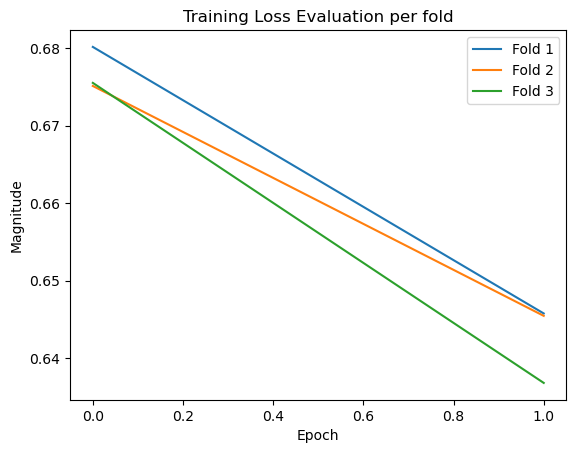

In [20]:
# Plot train losses
ax = plt.axes()
for fold_losses in train_losses:
    plt.plot(fold_losses)
plt.title('Training Loss Evaluation per fold')
plt.xlabel('Epoch')
plt.ylabel('Magnitude')
plt.legend(['Fold ' + str(x) for x in range(1, 11)])
plt.show()

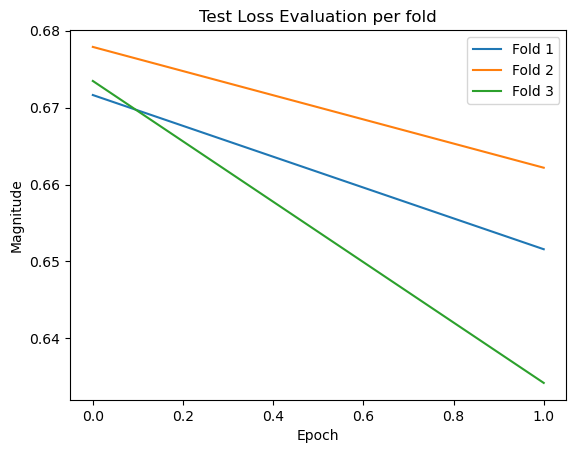

In [21]:
# Plot test losses
ax = plt.axes()
for fold_losses in test_losses:
    plt.plot(fold_losses)
plt.title('Test Loss Evaluation per fold')
plt.xlabel('Epoch')
plt.ylabel('Magnitude')
plt.legend(['Fold ' + str(x) for x in range(1, 11)])
plt.show()

In [22]:
# Get performance metrics by calculcating average of metrics across all folds
print("Final Performance Metrics")
print(f"Accuracy: {np.mean(results_accuracy)}")
print(f"Precision: {np.mean(results_precision)}")
print(f"Sensitivity: {np.mean(results_sensitivity)}")
print(f"Specificity: {np.mean(results_specificity)}")
print(f"F1: {np.mean(results_f1)}")

Final Performance Metrics
Accuracy: 0.6549826624453491
Precision: 0.0
Sensitivity: 0.0
Specificity: 1.0
F1: 0.0


### Show Predictions on Sample Images

In [23]:
sample_img_names = ["0000-0-A.tif", "0163-0-P.tif", "0198-0-A.tif"]
sample_img_paths = [(data_dir + "/" + sample_img_names[i]) for i in range(len(sample_img_names))]
sample_classes = [sample_img_names[i][5] for i in range(len(sample_img_names))]
sample_ground_truths = ["No Metastasis" if sample_classes[i] == 0 else "Metastasis" for i in range(len(sample_img_names))]
sample_imgs = [Image.open(img_path).convert('RGB') for img_path in sample_img_paths]
sample_imgs_show = [Image.open(img_path) for img_path in sample_img_paths]

In [24]:
validation_batch = torch.stack([preprocess(img).to(device) for img in sample_imgs])

In [25]:
sample_preds= model(validation_batch).detach().cpu().data.numpy()
sample_preds

array([[0.64366907, 0.356331  ],
       [0.6427341 , 0.35726595],
       [0.6453153 , 0.3546847 ]], dtype=float32)

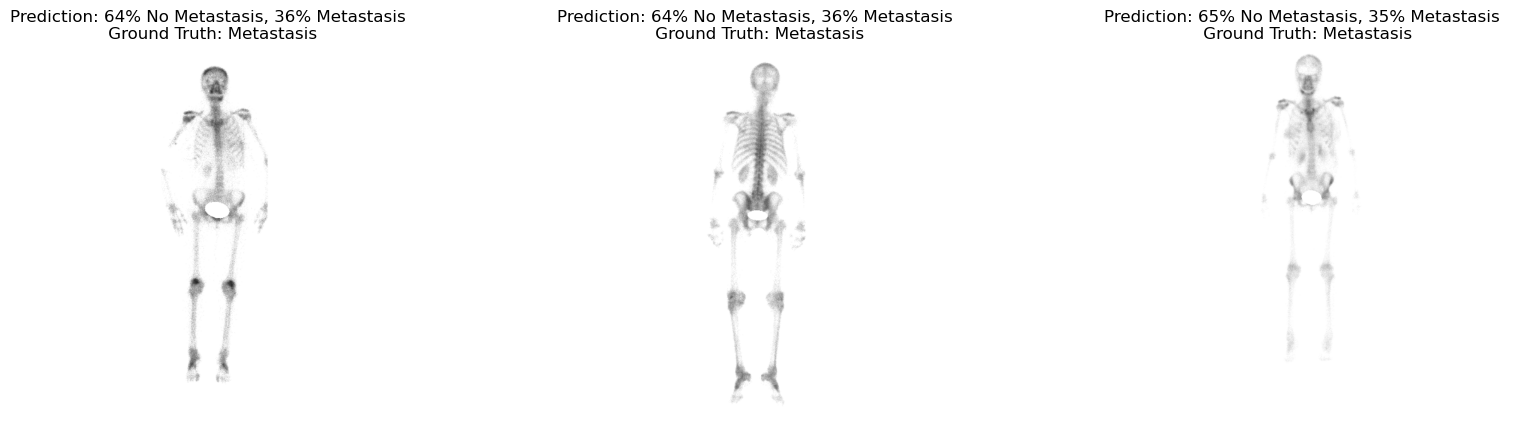

In [26]:
fig, axs = plt.subplots(1, len(sample_imgs_show), figsize=(20, 5))
for i, img in enumerate(sample_imgs_show):
    ax = axs[i]
    ax.axis('off')
    ax.set_title("Prediction: {:.0f}% No Metastasis, {:.0f}% Metastasis \n Ground Truth: {}"
                 .format(100*sample_preds[i,0], 100*sample_preds[i,1], sample_ground_truths[i]))
    ax.imshow(img)

In [27]:
# NOTE: Due to lack of library support for CUDA, this will error if using CUDA
# Get computational complexity
model = model.to("cpu")
stat(model, (3, 646, 220))

[MAdd]: Dropout is not supported!
[Flops]: Dropout is not supported!
[Memory]: Dropout is not supported!
[Flops]: Softmax is not supported!
[Memory]: Softmax is not supported!


C:\Users\Irish\anaconda3\envs\conv_env\lib\site-packages\torchstat\reporter.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(total_df)


                         module name  input shape output shape   params memory(MB)           MAdd          Flops  MemRead(B)  MemWrite(B) duration[%]    MemR+W(B)
0                       features.0.0    3 646 220   32 323 110    864.0       4.34   60,258,880.0   30,697,920.0   1708896.0    4547840.0      15.16%    6256736.0
1                       features.0.1   32 323 110   32 323 110     64.0       4.34    4,547,840.0    2,273,920.0   4548096.0    4547840.0       0.84%    9095936.0
2                       features.0.2   32 323 110   32 323 110      0.0       4.34    1,136,960.0    1,136,960.0   4547840.0    4547840.0       1.22%    9095680.0
3       features.1.conv.0.ds_conv1.0   32 323 110   32 323 110    288.0       4.34   19,328,320.0   10,232,640.0   4548992.0    4547840.0       4.71%    9096832.0
4       features.1.conv.0.ds_conv1.1   32 323 110   32 323 110     64.0       4.34    4,547,840.0    2,273,920.0   4548096.0    4547840.0       0.00%    9095936.0
5       features.1.con